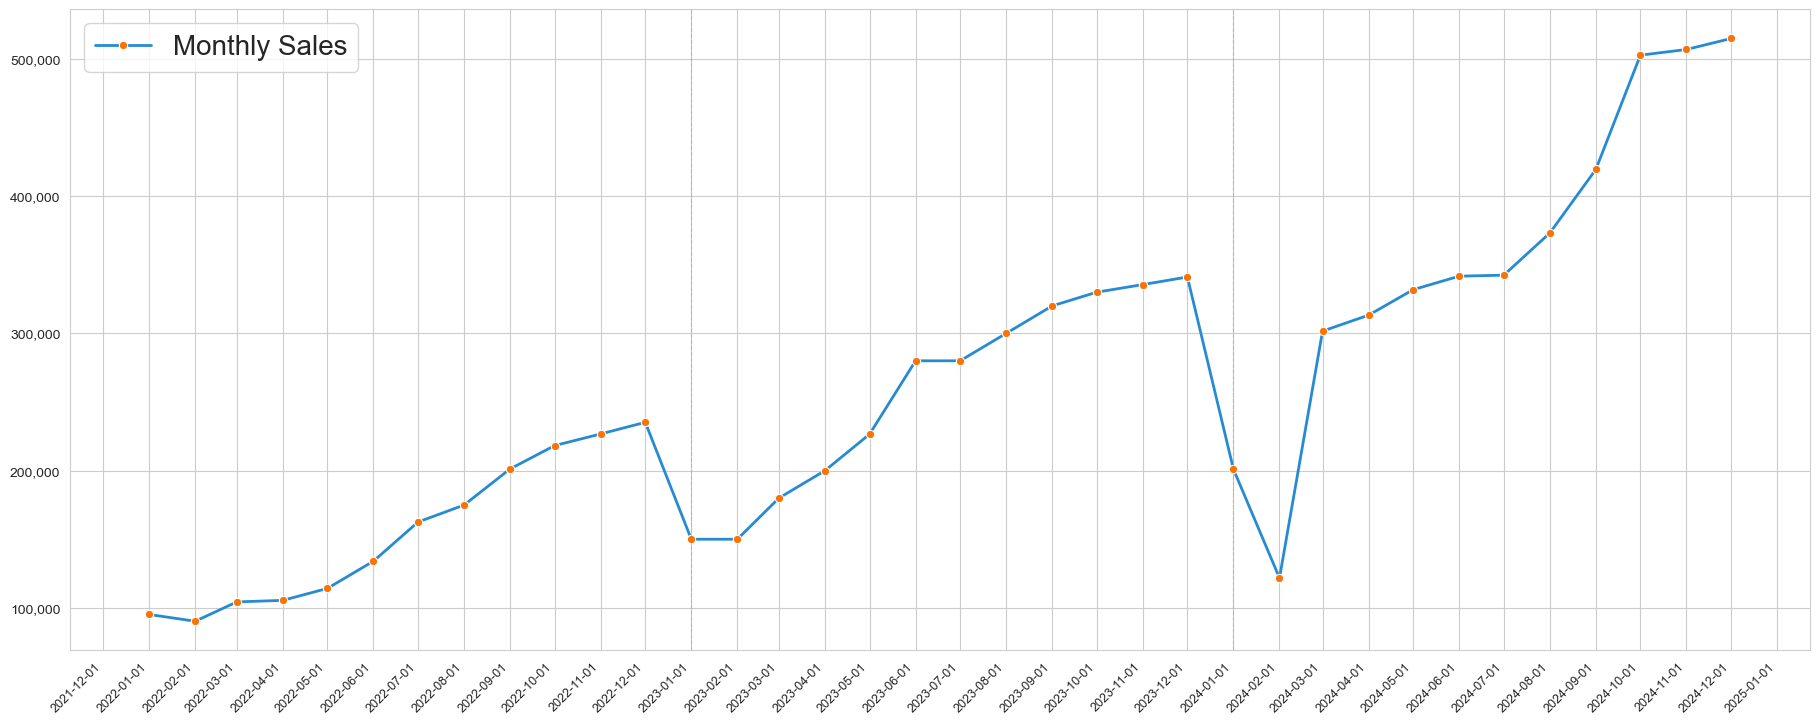

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import warnings

# 忽略所有 warning
warnings.filterwarnings("ignore")
# 设置样式
sns.set_style("whitegrid")
# 数据准备
dates = [
    "2022-01-01", "2022-02-01", "2022-03-01", "2022-04-01", "2022-05-01", "2022-06-01", 
    "2022-07-01", "2022-08-01", "2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01", 
    "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01", "2023-05-01", "2023-06-01", 
    "2023-07-01", "2023-08-01", "2023-09-01", "2023-10-01", "2023-11-01", "2023-12-01", 
    "2024-01-01", "2024-02-01", "2024-03-01", "2024-04-01", "2024-05-01", "2024-06-01", 
    "2024-07-01", "2024-08-01", "2024-09-01", "2024-10-01", "2024-11-01", "2024-12-01"
]

# 销量数据（单位：辆）
prices = [
    95180,   90268,   104338,  105475,  114183,  134036,   
    162530,  174915,  201259,  218228,  226712,  235197,   
    150000,  150000,  180000,  200000,  226523,  280000,    
    280000,  300000,  320000,  330000,  335521,   341043,   
    201019,  121748,  301631,  313245,  331817,  341658,   
    342383,  373083,  419426,  502657,  506804,  514809   
]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
# 创建画布并绘图
plt.figure(figsize=(20, 8))
sns.lineplot(x=dates, y=prices, marker='o', linewidth=2, color='#268bd2', 
             markerfacecolor='#f97306', label='Monthly Sales')
# 设置X轴格式
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Y轴千位分隔
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
# 年度分隔线
for year in range(dates[0].year + 1, dates[-1].year + 1):
    plt.axvline(datetime(year, 1, 1), color='gray', linestyle='--', linewidth=0.8, alpha=0.3)
# 标题与标签
plt.legend(loc='upper left', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=10)
# 布局调整
plt.tight_layout()
plt.subplots_adjust(bottom=0.18, left=0.08, right=0.95)
# 显示图形
plt.show()

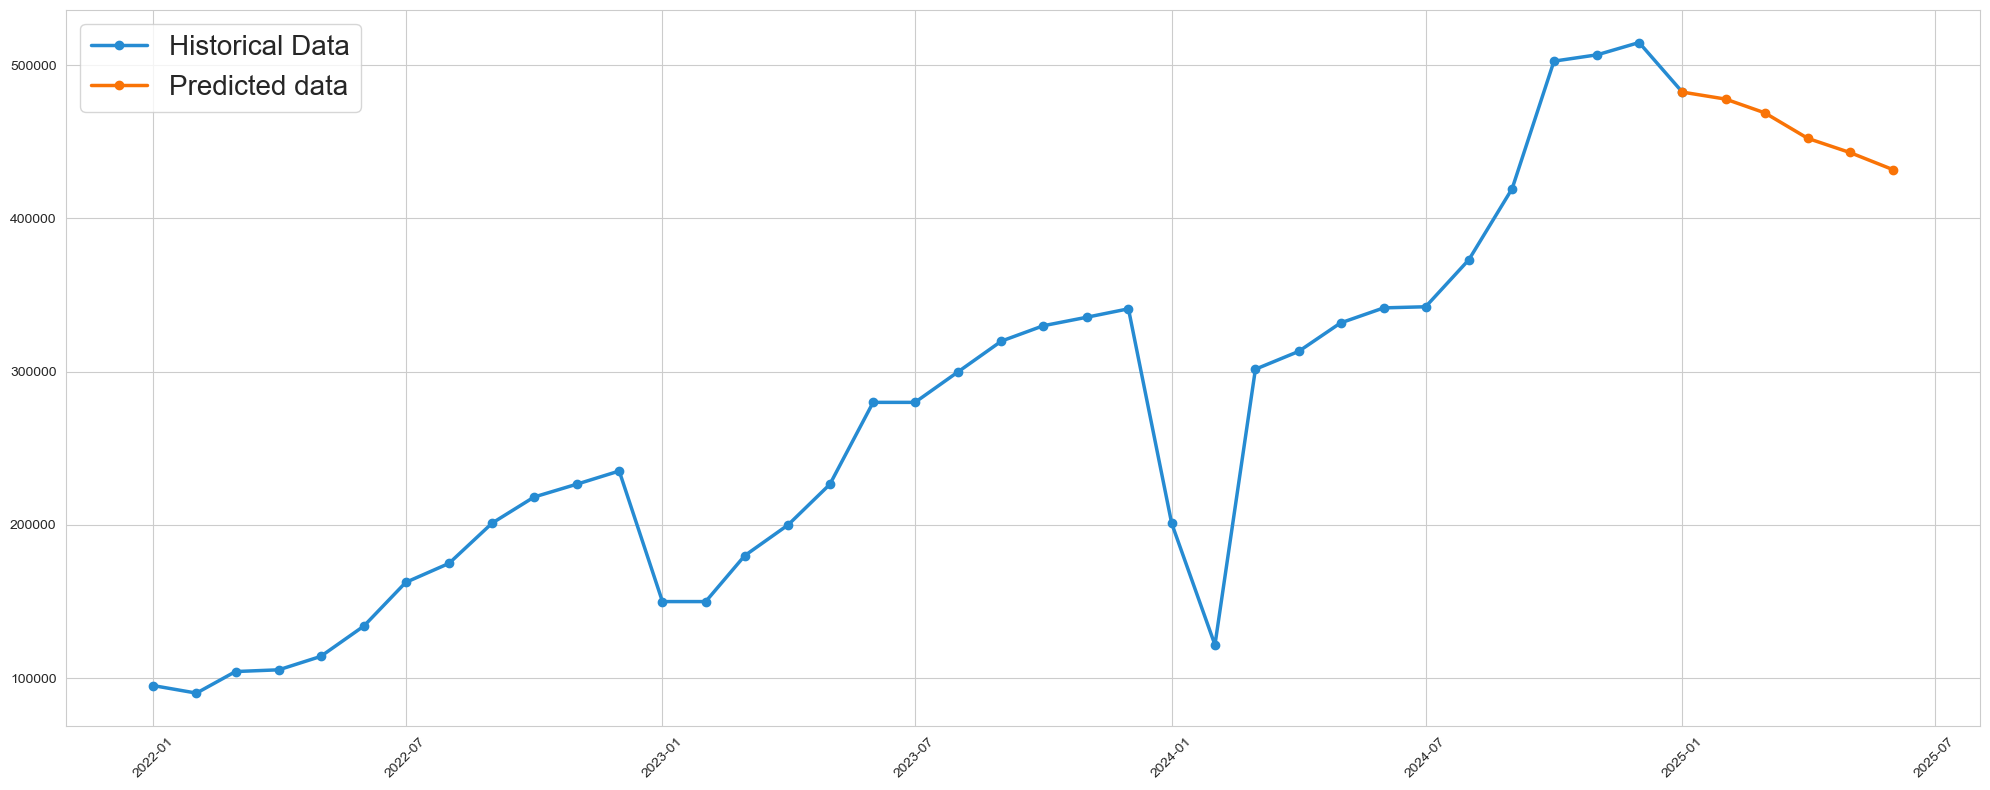

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime
# 原始数据
dates_str = [
    "2022-01-01", "2022-02-01", "2022-03-01", "2022-04-01", "2022-05-01", "2022-06-01", 
    "2022-07-01", "2022-08-01", "2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01", 
    "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01", "2023-05-01", "2023-06-01", 
    "2023-07-01", "2023-08-01", "2023-09-01", "2023-10-01", "2023-11-01", "2023-12-01", 
    "2024-01-01", "2024-02-01", "2024-03-01", "2024-04-01", "2024-05-01", "2024-06-01", 
    "2024-07-01", "2024-08-01", "2024-09-01", "2024-10-01", "2024-11-01", "2024-12-01"
]
prices = [
    95180,   90268,   104338,  105475,  114183,  134036,   
    162530,  174915,  201259,  218228,  226712,  235197,   
    150000,  150000,  180000,  200000,  226523,  280000,    
    280000,  300000,  320000,  330000,  335521,   341043,   
    201019,  121748,  301631,  313245,  331817,  341658,   
    342383,  373083,  419426,  502657,  506804,  514809   
]
# 创建 DataFrame
df = pd.DataFrame({
    "date": pd.to_datetime(dates_str),
    "price": prices
})
df.set_index("date", inplace=True)
# 归一化
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['price']])
# 创建训练数据
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)
look_back = 3
X, y = create_dataset(scaled_prices, look_back)
X = X.reshape((X.shape[0], look_back, 1))
# 构建 LSTM 模型
model = Sequential([
    LSTM(64, input_shape=(look_back, 1), activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)
# 预测未来6个月
last_input = scaled_prices[-look_back:].reshape(1, look_back, 1)
predictions = []
for _ in range(6):
    pred = model.predict(last_input, verbose=0)[0][0]
    predictions.append(pred)
    last_input = np.append(last_input[:, 1:, :], [[[pred]]], axis=1)
# 反归一化预测结果
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
# 拼接历史和预测数据
last_date = df.index[-1]
future_dates = [last_date + pd.DateOffset(months=i+1) for i in range(6)]
df_future = pd.DataFrame({'price': predicted_prices}, index=future_dates)
df_all = pd.concat([df, df_future])
# 提取坐标
all_dates = df_all.index
all_prices = df_all['price'].values
# 分段画图
plt.figure(figsize=(20, 8))
ax = plt.gca()
# 历史段：包括最后一个历史点
ax.plot(all_dates[:len(df)+1], all_prices[:len(df)+1], color='#268bd2', linewidth=2.5, marker='o', label='Historical Data')
# 预测段：从历史最后一个点开始连接
ax.plot(all_dates[len(df):], all_prices[len(df):], color='#f97306', linewidth=2.5, marker='o', label='Predicted data')
# 美化图表
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()